# Credit portfolio modelling and CDO tranche pricing

Authors: Youssouf Bancé (20234008@etud.univ-evry.fr) and Youssef Louraoui (20230348@etud.univ-evry.fr)

## 1. Credit portfolio modelling

The code is designed to simulate the risk of a credit portfolio using Monte Carlo methods. It consists of several parts, each focusing on a specific aspect of the simulation, from setting up the initial parameters and loading data to running simulations and plotting results.

### 1.1 Libraries

The code begins by importing necessary Python libraries. pandas is used for data manipulation, numpy for numerical operations, math for mathematical functions, and matplotlib.pyplot for plotting. scipy.stats.norm is used for calculations related to the normal distribution, essential in risk modeling.

Import necessary libraries:
- `pandas`: For data manipulation and analysis.
- `numpy`: For numerical operations.
- `math`: Provides access to mathematical functions.
- `scipy.stats`: For statistical functions, specifically `norm` for normal distribution related calculations.
- `matplotlib.pyplot`: For plotting graphs and visualizations.

In [26]:
# We import the libraries needed for our processing and calculations
import pandas as pd
import numpy as np
import math as mt 
from scipy.stats import norm
import matplotlib.pyplot as plt

### 1.2 Setting up Monte Carlo simulation parameters

Key parameters for the Monte Carlo simulation are defined here. This includes the number of simulations (N), global correlation factor (rho), number of portfolio entities (n), maturity (m), random variables for financial sectors (Xs), and sector-specific correlations (rhos). These parameters are crucial for simulating realistic scenarios in risk analysis.

Define key parameters for the Monte Carlo simulation:
- `N`: Total number of simulations (10,000) to ensure statistical significance.
- `rho`: Global correlation factor (0.11), indicating the overall interconnectedness of the entities in the portfolio.
- `n`: Number of entities in the credit portfolio (250).
- `m`: Maturity period in years (3 years) for which the credit risk is assessed.
- `Xs`: Random variables representing the systematic risk factors for each of the 6 financial sectors.
- `rhos`: Correlation coefficients for each financial sector, reflecting how much each sector's performance is related to the systematic risk.
- `IC`: Confidence interval level (99%) commonly used in risk management for calculating Value at Risk (VaR).

In [27]:
#Parameters

N=10000   #Number of simulations
rho=0.11  #Global correlation
n=250     #number of componants of our portfolio
m=3       #maturity(years)
Xs=np.random.normal(0,1,6) #we generate Xs for each financial sector 
rhos=[0.23,0.32,0.15,0.18,0.2,0.16] #correlation for each financial sector
IC=0.99 #confidence interval level

### 1.3 Loading and preparing the data

Portfolio data and Probability of Default (PD) data are loaded from an Excel file. Merging these data sets allows for the association of PD values with individual portfolio entities. This step is vital for simulating credit events (like defaults) based on the creditworthiness of different entities.

We start by loading portfolio data and the first 10 rows are displayed for a quick overview.

In [28]:
#Portfolio table view

# Load data from Excel file - this path will need to be updated for your specific environment

file_path = '/Users/youssef/Downloads/Credit_Portfolio.xls'

Pf_data = pd.read_excel(file_path, sheet_name='Portfolio')
Pf_data.head(10)

,Id,Exposure,Rating,LGD,Sector
0,1,1630.848109,A2,0.28,Financials
1,2,1221.503342,B3,0.18,Utilities
2,3,1157.322916,Aa3,0.01,Utilities
3,4,1116.214484,Ba3,0.48,Energy
4,5,1030.671102,Caa1,0.05,Consumer Non Cyclical
5,6,1743.064669,Ba1,0.50,Utilities
6,7,1785.607471,Baa1,0.36,Utilities
7,8,1234.046449,Baa1,0.27,Technology
8,9,1967.558824,Baa1,0.71,Technology
9,10,1079.653310,A3,0.45,Technology


We load and format probability of default (PD) data as a function of credit rating.

In [29]:
#Viewing of one-year,three-years and five years probability of default  as a function of rating
PD_rating = pd.read_excel(file_path, sheet_name="Params",skiprows=range(1,5), nrows=19,header=None).iloc[1:19,:4]
PD_rating.rename(columns={PD_rating.columns[0]: 'Rating'}, inplace=True)
PD_rating

,Rating,1,2,3
1,Aaa,0.00003,0.00003,0.00003
2,Aa1,0.000062,0.000186,0.00031
3,Aa2,0.000136,0.000408,0.00068
4,Aa3,0.000284,0.000852,0.00142
5,A1,0.000522,0.001566,0.00261
6,A2,0.000934,0.002802,0.00467
7,A3,0.00146,0.00438,0.0073
8,Baa1,0.0022,0.0066,0.011
9,Baa2,0.00316,0.00948,0.0158
10,Baa3,0.0061,0.0183,0.0305


We merge portfolio data with PD rating data, associating each portfolio component with its PD.

In [30]:
#Merge the Portfolio table and the previous table to obtain the probability of default associated with each component of our portfolio
Merged_table = pd.merge(Pf_data, PD_rating, on='Rating',how="left")
Merged_table

,Id,Exposure,Rating,LGD,Sector,1,2,3
0,1,1630.848109,A2,0.28,Financials,0.000934,0.002802,0.00467
1,2,1221.503342,B3,0.18,Utilities,0.0541,0.1623,0.2705
2,3,1157.322916,Aa3,0.01,Utilities,0.000284,0.000852,0.00142
3,4,1116.214484,Ba3,0.48,Energy,0.02372,0.07116,0.1186
4,5,1030.671102,Caa1,0.05,Consumer Non Cyclical,0.072628,0.217884,0.36314
...,...,...,...,...,...,...,...,...
245,246,1120.487075,A1,0.40,Technology,0.000522,0.001566,0.00261
246,247,1106.265450,B3,0.64,Consumer Non Cyclical,0.0541,0.1623,0.2705
247,248,1816.736351,A3,0.31,Technology,0.00146,0.00438,0.0073
248,249,1809.686575,Ba1,0.24,Utilities,0.01056,0.03168,0.0528


We create and merge a DataFrame that maps each financial sector with its corresponding systematic risk factor (`Xs`) and correlation coefficient (`rhos`).

In [31]:
#Table of Xs and rhos by sector
Sector=["Utilities","Financials" ,"Energy","Consumer Non Cyclical","Technology","Consumer Cyclical"] 
Sector_rho_X= pd.DataFrame({'Sector': Sector, 'Xs': Xs,'rhos': rhos})
Sector_rho_X

,Sector,Xs,rhos
0,Utilities,0.780720,0.23
1,Financials,0.667474,0.32
2,Energy,1.032621,0.15
3,Consumer Non Cyclical,-0.269027,0.18
4,Technology,0.839409,0.20
5,Consumer Cyclical,0.924197,0.16


We extract individual components required for the Monte Carlo simulation, including Exposure at Default (EAD), Loss Given Default (LGD), and PDs for different maturities.

In [32]:
#Merge in between the first merge and the table of Xs and rhos by sector to obtain the Xs and rhos for each component of our portfolio
Merged_table_1= pd.merge(Merged_table, Sector_rho_X, on='Sector',how="left")
Merged_table_1

,Id,Exposure,Rating,LGD,Sector,1,2,3,Xs,rhos
0,1,1630.848109,A2,0.28,Financials,0.000934,0.002802,0.00467,0.667474,0.32
1,2,1221.503342,B3,0.18,Utilities,0.0541,0.1623,0.2705,0.780720,0.23
2,3,1157.322916,Aa3,0.01,Utilities,0.000284,0.000852,0.00142,0.780720,0.23
3,4,1116.214484,Ba3,0.48,Energy,0.02372,0.07116,0.1186,1.032621,0.15
4,5,1030.671102,Caa1,0.05,Consumer Non Cyclical,0.072628,0.217884,0.36314,-0.269027,0.18
...,...,...,...,...,...,...,...,...,...,...
245,246,1120.487075,A1,0.40,Technology,0.000522,0.001566,0.00261,0.839409,0.20
246,247,1106.265450,B3,0.64,Consumer Non Cyclical,0.0541,0.1623,0.2705,-0.269027,0.18
247,248,1816.736351,A3,0.31,Technology,0.00146,0.00438,0.0073,0.839409,0.20
248,249,1809.686575,Ba1,0.24,Utilities,0.01056,0.03168,0.0528,0.780720,0.23


### 1.4 Data extraction for the Monte Carlo simulation

Systematic risk factors, correlation coefficients, exposures, and LGDs are extracted. This data is essential for the calculation of potential losses in the portfolio. PD values for different maturities are also extracted, and default barriers are calculated, setting the thresholds for default events in the simulation.

In [33]:
#Data used in the modelling part   
Xs=Merged_table_1["Xs"] #Xs for each component of our portfolio
rhos=Merged_table_1["rhos"]  #Xs for each component of our portfolio
EAD=Merged_table_1["Exposure"] #Exposure at default for each component of our portfolio
LGD=Merged_table_1["LGD"] #Loss given default for each component of our portfolio
PD1Y=Merged_table_1[1] #one-year Probability of default  for each component of our portfolio 
PD3Y=Merged_table_1[2] #three-years Probability of default  for each component of our portfolio 
PD5Y=Merged_table[3] #five-years Probability of default  for each component of our portfolio 
B1Y=[norm.ppf(x) for x in PD1Y] #Default Barrier for 1-year Probability of default 
B3Y=[norm.ppf(x) for x in PD3Y] #Default Barrier for 3-year Probability of default 
B5Y=[norm.ppf(x) for x in PD5Y] #Default Barrier for 5-year Probability of default 

### 1.5 Monte Carlo simulation functions

We use Monte Carlo simulation, a statistical technique used to understand the impact of risk and uncertainty in prediction and forecasting models. In finance, it's often used for risk assessment and valuation. Several functions are defined to facilitate the Monte Carlo simulation. These include generating systematic (X) and idiosyncratic (epsilon) risk factors, calculating asset values (Zi), determining default events, and computing individual and total portfolio losses. These functions collectively simulate the credit risk of the portfolio under various scenarios.

#### Defining Functions for Monte Carlo Simulation
- Define a function to generate a common systematic risk factor 'X' for the entire portfolio.
- Define a function to generate idiosyncratic risk factors 'epsilon' for each portfolio component.
- Define a function to generate asset values 'Zi' for each component, incorporating both systematic and idiosyncratic risks.
- Define a function to calculate default events based on the maturity period and default barriers.
- Define a function to compute the loss for each component in case of default.
- Define a function to calculate the total portfolio loss in each simulation.
- Define the main Monte Carlo simulation function `MC()` that runs all simulations and stores the results.

In [34]:
# We run a simulation with this steps

#We generate X whixh is the same for each component of our portfolio
def generateX():
    X=np.random.normal(0,1)
    return X 
#We generate the n espsilons for each component of our portfolio
def generate_epsilon():
    eps=np.random.normal(0,1,n)
    return eps

#We generate the Zi for each component of our portfolio
def generateZ():
    eps=generate_epsilon()
    X=generateX()
    Zlist=[]
    for i in range(0,n):
        Z=mt.sqrt(rho)*X+mt.sqrt(rhos[i]-rho)*Xs[i]+mt.sqrt(1-rhos[i])*eps[i]
        Zlist.append(Z) 
       
    return Zlist

We calculate the default barriers for different maturities using the norm.ppf function, which represents the inverse of the cumulative distribution function of the normal distribution.

In [35]:
#We generate a binary variable taking 1 if a component of our portfolio fails, 0 otherwise. 
#This variable based on maturity because the barrier depends of maturity

def calcul_default( ):
    Zlist=generateZ()
    Default=[]
    if  m==1:
        for i in range(0,n):
            if Zlist[i]<B1Y[i]:
                Default.append(1)
            else: 
                Default.append(0) 
        
    elif m==3:
        for i in range(0,n):
            if Zlist[i]<B3Y[i]:
                Default.append(1)
            else: 
                Default.append(0) 
        
    else:  
        for i in range(0,n):
            if Zlist[i]<B5Y[i]:
                Default.append(1)
            else: 
                 Default.append(0)    
        
             
    return  Default   

We define a function to compute the loss for each component in case of default.

In [36]:
#We generate the loss for each component of our portfolio
def calcul_loss():
    Default=calcul_default()
    Loss=[]
    for i in range(0,n):
        L=Default[i]*EAD[i]*LGD[i]
        Loss.append(L)   
        
    return Loss

We define a function to calculate the total portfolio loss in each simulation.

In [37]:
#We calculate the total loss of our portfolio     
def calcul_loss_portfolio():
    Loss=calcul_loss()
    return sum(Loss)  

We define the main Monte Carlo simulation function `MC()` that runs all simulations and stores the results.

In [38]:
# We run the N simulations
    
def MC():
    #Create a matrix with N rows and 4n+2  columns
    columns=['X'] + [f'epsilon{i}' for i in range(1, n+1)] + [f'Z{i}' for i in range(1, n+1)] + [f'Default{i}' for i in range(1, n+1)] + [f'Loss{i}' for i in range(1, n+1)] + ['Loss_Portfolio']
    matrice= pd.DataFrame(np.empty((N, 4*n+2)), columns=columns)
    #Matrix filling
    for j in range(0,N):
        matrice.loc[j]=[generateX(),*generate_epsilon(),*generateZ(),*calcul_default(),*calcul_loss(),calcul_loss_portfolio()]    
    return matrice

#Results of each simulation. At the end ,we have the loss of portfolio for each simulation
Results=MC()
Results


,X,epsilon1,epsilon2,epsilon3,epsilon4,epsilon5,epsilon6,epsilon7,epsilon8,epsilon9,...,Loss242,Loss243,Loss244,Loss245,Loss246,Loss247,Loss248,Loss249,Loss250,Loss_Portfolio
0,-0.292513,1.354519,2.189105,-0.108026,-0.357714,1.077006,-0.210672,-0.428147,0.035450,-1.685316,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,18564.177374
1,1.378759,0.120348,0.542163,-1.785165,-2.375637,1.271945,-0.020127,1.264301,0.497474,0.178162,...,0.0,0.000000,0.0,0.0,0.0,708.009888,0.0,0.0,0.0,3724.588458
2,1.639396,-2.214860,-2.490107,1.826575,-0.010550,0.962018,0.249326,0.355418,0.570832,-0.081071,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,15247.455061
3,2.429390,0.586281,0.843901,1.454832,-1.435462,-1.193784,-0.553533,-0.643468,0.323175,-0.016111,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,4272.166814
4,-0.230182,1.048195,-0.840658,0.481798,0.784663,1.410451,-0.351931,0.027837,1.415408,-1.890704,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,13044.055300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.496336,0.982153,-1.849887,0.367489,1.490767,1.805446,1.373633,-1.230253,-0.111113,1.147717,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,11958.467055
9996,-0.018086,-0.826754,0.855257,-1.254997,1.073061,-0.591160,-1.658116,0.751728,-0.697467,-0.045945,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,9448.375500
9997,0.959461,-1.567888,-0.992363,0.139264,0.315840,-0.631125,0.496404,1.129991,0.229756,0.105264,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,5793.673208
9998,0.587734,-0.043973,-1.014047,0.639823,0.954112,-0.606296,0.586944,-0.130644,-0.852711,0.166020,...,0.0,0.000000,0.0,0.0,0.0,708.009888,0.0,0.0,0.0,14148.085269


### 1.6 Risk analysis for the credit portofolio 

The Monte Carlo simulation (MC()) is run, producing a comprehensive set of results for each simulation. Subsequently, key risk metrics like Expected Loss, VaR, and Expected Shortfall are calculated. These metrics provide insights into the average, worst-case, and extreme loss scenarios of the portfolio.

These are key metrics in financial risk management. VaR provides a threshold value such that the probability of losses exceeding this value is at a given confidence level. Expected Shortfall is the average of losses that exceed the VaR, offering insight into potential extreme losses.

- Run the Monte Carlo simulations using the `MC()` function and store the results.
- Calculate key risk indicators: Expected Loss, Value at Risk (VaR), and Expected Shortfall. These metrics provide insights into the average loss, the worst-case loss at a given confidence level, and the average of the most extreme losses, respectively.
- Create a DataFrame to display these risk indicators for easy interpretation.

In [39]:
#Risk indicators
Expected_Loss=Results['Loss_Portfolio'].mean() #average of the loss distribution
VAR=Results['Loss_Portfolio'].quantile(IC)   #Value-at-risk (quantile of order 0.99 of the loss distribution )
Expected_ShortFall=Results['Loss_Portfolio'][Results['Loss_Portfolio'] > VAR].mean() #Expected-Shortfall (average of the losses above the var)

statistics=pd.DataFrame({'Indicator': ['Expected_Loss', 'VAR(IC)', 'Expected_ShortFall'],'Value': [Expected_Loss, VAR, Expected_ShortFall]})
statistics

,Indicator,Value
0,Expected_Loss,7738.711050
1,VAR(IC),24152.464135
2,Expected_ShortFall,27657.060625


#### Preparing Data for Convergence Graph of Portfolio Losses

Rolling statistics (mean, standard error, confidence intervals) are computed for the portfolio losses. This part of the code prepares data for visualizing how the loss estimates stabilize as the number of simulations increases, which is crucial for validating the reliability of the Monte Carlo method.

- Create a DataFrame to store rolling statistics like mean, standard error, and confidence interval bounds for the portfolio losses.
- Calculate rolling mean, standard error, and confidence interval bounds for each simulation iteration.
- The rolling statistics illustrate the stabilization of estimated losses as the number of simulations increases, a key aspect of Monte Carlo simulation reliability.

In [40]:
#Calculations to plot the graph

#Create a matrix with N-1 rows and 5 columns
columns=['Rolling mean','sigma(N)','Bound-','Bound+','spread']
val= pd.DataFrame(np.empty((N-1,5)), columns=columns)

#Matrix filling
val['Rolling mean']=[Results['Loss_Portfolio'][0:i+1].mean() for i in range(1,N)] # rolling mean of the loss distribution
val.loc[0, ['Bound-', 'Bound+', 'spread', 'sigma(N)']] = 0  
for i in range(1,N-1):
    val.loc[i, 'sigma(N)'] = np.std(val['Rolling mean'][:i+1]) #rolling standard error of the rollig mean of loss distribution
    val.loc[i, 'Bound-'] = val.loc[i, 'Rolling mean'] - norm.ppf(IC) * (val.loc[i, 'sigma(N)'] / mt.sqrt(i+2)) #Negative confidence interval bound
    val.loc[i, 'Bound+'] = val.loc[i, 'Rolling mean'] + norm.ppf(IC) * (val.loc[i, 'sigma(N)'] / mt.sqrt(i+2)) #Positive confidence interval bound
    val.loc[i, 'spread'] = val.loc[i, 'Bound+'] - val.loc[i, 'Bound-'] #spread between the confidence interval bounds
        
val    

,Rolling mean,sigma(N),Bound-,Bound+,spread
0,11144.382916,0.000000,0.000000,0.000000,0.000000
1,12512.073631,683.845358,11593.588915,13430.558347,1836.969432
2,10452.096927,855.916780,9456.516836,11447.677017,1991.160181
3,10970.488601,761.117409,10178.641536,11762.335667,1583.694131
4,12870.548367,934.581856,11982.950237,13758.146496,1775.196259
...,...,...,...,...,...
9994,7738.551955,190.107633,7734.128505,7742.975405,8.846899
9995,7738.722989,190.102503,7734.299880,7743.146098,8.846218
9996,7738.528445,190.097386,7734.105676,7742.951214,8.845538
9997,7739.169465,190.092225,7734.747037,7743.591892,8.844855


### 1.7 Plotting the convergence graph

Finally, the convergence graph is plotted. This visualization demonstrates the stabilization of loss estimates, an important aspect of Monte Carlo simulations. It helps in assessing the sufficiency of the number of simulations and the overall reliability of the simulated risk metrics. This is crucial for Monte Carlo simulations, as it indicates the stability and reliability of the results. Convergence graphs show whether increasing the number of simulations leads to stable estimates of the portfolio losses.

- We prepare the x-axis (number of simulations) and y-axis data (rolling mean, lower bound, upper bound) for the plot.

In [41]:
# Data to Plot the Convergence Graph

x = range(1,N)  # the number of simulations for the x-axis


y1 = val['Rolling mean'] #values for y-axis
y2 = val['Bound-'] #values for y-axis 
y3 = val['Bound+'] #values for y-axis 

- We create and customize the convergence graph using `matplotlib.pyplot`.
- The graph visualizes how the estimated loss of the portfolio stabilizes with increasing number of simulations, showcasing the reliability of the Monte Carlo simulation in risk assessment.

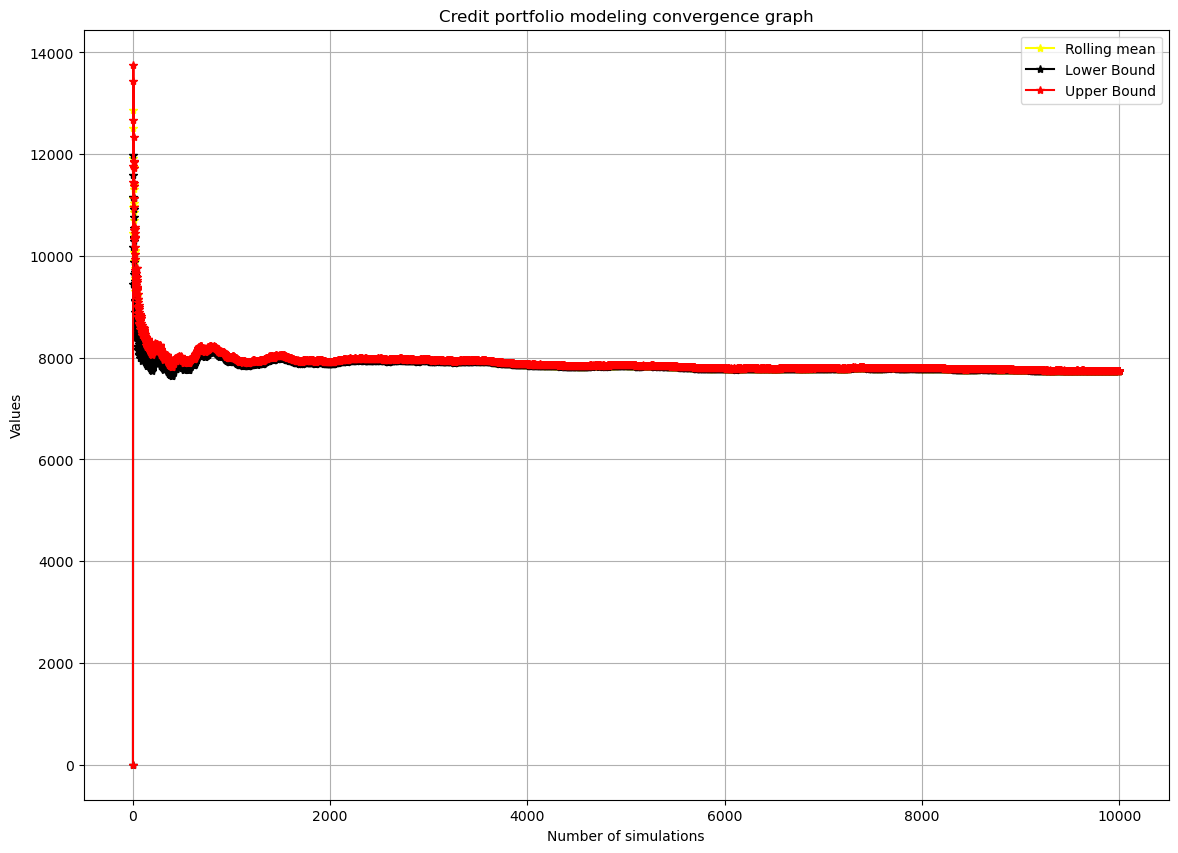

In [42]:
# Plotting the Convergence Graph
plt.figure(figsize=(14, 10))
plt.plot(x, y1, marker='*', linestyle='-', color='yellow', label='Rolling mean')
plt.plot(x, y2, marker='*', linestyle='-', color='black', label='Lower Bound')
plt.plot(x, y3, marker='*', linestyle='-', color='red', label='Upper Bound')

plt.xlabel('Number of simulations')
plt.ylabel('Values')
plt.title('Credit portfolio modeling convergence graph')
plt.legend()
plt.grid(True)
plt.show()

The code provides a comprehensive approach to assessing credit risk in a portfolio using Monte Carlo simulations. It blends statistical techniques with financial risk modeling principles, offering valuable insights into the potential losses and risk exposure of a credit portfolio.

## 2. Credit derivatives modelling of CDO tranches

### 2.1 Setting up parameters for CDO modeling

- strike: This is the threshold value for CDO tranching, essentially the point at which losses in the portfolio start impacting the tranche.
- size: This refers to the size of the tranche being modeled.
- m: Maturity in years, indicating the time horizon over which the CDO is considered.

In [43]:
#Credit derivatives modelling

strike=7 #strike 
size=2   #size
m=5      #maturity(years)

### 2.2 Conducting Monte Carlo simulations

- Results = MC(): This line runs the Monte Carlo simulation function MC(), which simulates the portfolio's loss for each iteration. 
- The function is expected to return a collection of simulated results.

In [44]:
#Results of each simulation. At the end ,we have the loss of portfolio for each simulation
Results=MC()
Results

,X,epsilon1,epsilon2,epsilon3,epsilon4,epsilon5,epsilon6,epsilon7,epsilon8,epsilon9,...,Loss242,Loss243,Loss244,Loss245,Loss246,Loss247,Loss248,Loss249,Loss250,Loss_Portfolio
0,-0.047446,1.588576,-0.046330,-1.641327,0.571986,-0.194033,-0.392592,-0.036095,0.651467,1.891049,...,0.0,450.312204,0.0,0.0,0.0,708.009888,0.0,0.0,427.003998,19680.500504
1,1.139640,0.653081,-0.656859,0.793300,0.771869,0.512287,0.332026,0.126468,-0.280798,-1.234253,...,0.0,450.312204,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,12844.946745
2,-0.521851,1.123583,-0.233929,1.322266,-0.152058,-0.551596,-0.373750,-1.651653,-1.544856,0.995556,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,9053.827631
3,1.054587,0.233964,-0.153795,-0.930559,-0.792686,1.979899,0.481207,0.857442,-0.502162,0.980644,...,0.0,0.000000,0.0,0.0,0.0,708.009888,0.0,0.0,0.000000,2075.106967
4,-0.253436,0.387521,-0.315331,0.046531,-0.934428,0.197951,-0.137708,0.030731,-0.275004,-0.979394,...,0.0,0.000000,0.0,0.0,0.0,708.009888,0.0,0.0,0.000000,13781.333659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.491020,1.266004,-2.185051,1.415246,-0.294278,-0.729827,1.679990,0.548866,0.083333,-0.661296,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,12491.649220
9996,0.838754,1.069044,0.420501,-0.367297,0.267901,-0.430620,-0.422242,0.954464,-0.679360,0.529622,...,0.0,0.000000,0.0,0.0,0.0,708.009888,0.0,0.0,0.000000,13782.718894
9997,0.856294,0.743957,1.607224,-2.280786,1.022657,0.016668,0.801859,-0.615755,-1.090233,-0.805346,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,9434.006165
9998,0.591197,-0.772534,-1.716677,-0.688745,0.452667,-0.824137,0.639630,-1.766578,0.098751,0.774956,...,0.0,0.000000,0.0,0.0,0.0,708.009888,0.0,0.0,0.000000,10212.421033


### 2.3 Creating a DataFrame for results

- A DataFrame named Tranche is created to store the results with specific columns: 'loss_portfolio%', '/Strike', '/Size', '/Tranche'.
- The DataFrame is used to calculate various aspects of the CDO tranching based on the results of the Monte Carlo simulation.

In [45]:
#Create a matrix with N rows and 4 columns
columns=['loss_portfolio%','/Strike','/Size','/Tranche']
Tranche= pd.DataFrame(np.empty((N,4)), columns=columns)

### 2.4 Filling the DataFrame with calculated values

- loss_portfolio%: This column calculates the loss of the portfolio as a percentage of the total credit granted for each simulation.
- /Strike: Calculates how much the portfolio loss exceeds the strike value.
- /Size: Determines the portion of loss covered by the tranche size.
- /Tranche: Calculates the percentage cost or value of the CDO tranche.

In [46]:
#Matrix filling
Tranche['loss_portfolio%']=[(L/sum(EAD))*100 for L in Results['Loss_Portfolio']] #Portfolio loss for each simulation as a percentage of the total credit granted
Tranche['/Strike']=[sorted([P, strike])[-1]-strike for P in Tranche['loss_portfolio%']] #This column takes 0 if the first column is below the strike or the difference between the first column and the strike if it is above the strike
Tranche['/Size']=[min(S,size) for S in Tranche['/Strike']] #This column takes the minimum between the second column and the size
Tranche['/Tranche']=[(T/size)*100 for T in Tranche['/Size']] #we calculate the price of the Collateralized Debt Obligation (CDO) by dividing the third column by the size
Tranche

,loss_portfolio%,/Strike,/Size,/Tranche
0,5.270648,0.0,0.0,0.0
1,3.440014,0.0,0.0,0.0
2,2.424712,0.0,0.0,0.0
3,0.555736,0.0,0.0,0.0
4,3.690788,0.0,0.0,0.0
...,...,...,...,...
9995,3.345397,0.0,0.0,0.0
9996,3.691159,0.0,0.0,0.0
9997,2.526528,0.0,0.0,0.0
9998,2.734995,0.0,0.0,0.0


### 2.5 Calculating risk indicators

- Expected_Price: The expected price of the CDO, calculated as the mean of the '/Tranche' column.
- VAR: The Value-at-Risk at the specified confidence interval, a critical risk metric in finance.

In [47]:
#Risk indicators
Expected_Price=Tranche['/Tranche'].mean() #average of  the price of the Collateralized Debt Obligation (CDO)
VAR=Tranche['/Tranche'].quantile(IC)  #Value-at-risk (quantile of order 0.99 of the price of the CDO  )

statistics=pd.DataFrame({'Indicator': ['Expected_Price', 'VAR(99%)'],'Value': [Expected_Price, VAR] })
statistics

,Indicator,Value
0,Expected_Price,3.502802
1,VAR(99%),100.000000


### 2.6 Creating a DataFrame for risk indicators

- This DataFrame displays the calculated risk indicators, 'Expected_Price' and 'VAR(99%)', providing a quick and clear reference to these key metrics.

In [48]:
#Calculations to plot the graph

#Create a matrix with N-1 rows and 5 columns
columns=['Rolling mean','sigma(N)','Bound-','Bound+','spread']
val= pd.DataFrame(np.empty((N-1,5)), columns=columns)

#Matrix filling
val['Rolling mean']=[Tranche['/Tranche'][0:i+1].mean() for i in range(1,N)] # rolling mean of the price of the CDO
val.loc[0, ['Bound-', 'Bound+', 'spread', 'sigma(N)']] = 0  
for i in range(1,N-1): 
    val.loc[i, 'sigma(N)'] = np.std(val['Rolling mean'][:i+1]) #rolling standard error of the rollig mean of the price of the CDO
    val.loc[i, 'Bound-'] = val.loc[i, 'Rolling mean'] - norm.ppf(IC) * (val.loc[i, 'sigma(N)'] / mt.sqrt(i+2)) #Negative confidence interval bound
    val.loc[i, 'Bound+'] = val.loc[i, 'Rolling mean'] + norm.ppf(IC) * (val.loc[i, 'sigma(N)'] / mt.sqrt(i+2)) #Positive confidence interval bound
    val.loc[i, 'spread'] = val.loc[i, 'Bound+'] - val.loc[i, 'Bound-'] #spread between the confidence interval bounds
        
val    

,Rolling mean,sigma(N),Bound-,Bound+,spread
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
9994,3.504204,0.278773,3.497718,3.510691,0.012973
9995,3.503854,0.278763,3.497368,3.510340,0.012972
9996,3.503503,0.278753,3.497018,3.509989,0.012971
9997,3.503153,0.278743,3.496668,3.509638,0.012970


### 2.7 Preparing data for convergence graph plotting

- A DataFrame val is created to store rolling statistics necessary for plotting.
- It includes columns for rolling mean, standard deviation, and confidence interval bounds.

These statistics are crucial for analyzing the convergence and stability of the CDO pricing model as the number of simulations increases.

In [49]:
# Data to Plot the Convergence Graph

x = range(1,N)  # the number of simulations for the x-axis


y1 = val['Rolling mean'] #values for y-axis
y2 = val['Bound-'] #values for y-axis 
y3 = val['Bound+'] #values for y-axis 

### 2.8 Calculating rolling statistics for aach simulation and plotting the convergence graph

- Rolling mean, standard deviation, and confidence interval bounds are calculated for each simulation iteration.
- These statistics are essential for assessing the reliability and accuracy of the Monte Carlo simulation.
- The convergence graph is plotted using matplotlib.pyplot.
- It displays the rolling mean and confidence interval bounds, showcasing how the estimated CDO prices stabilize with an increasing number of simulations.

This graph is important for visualizing the convergence and assessing the adequacy of the number of simulations performed.

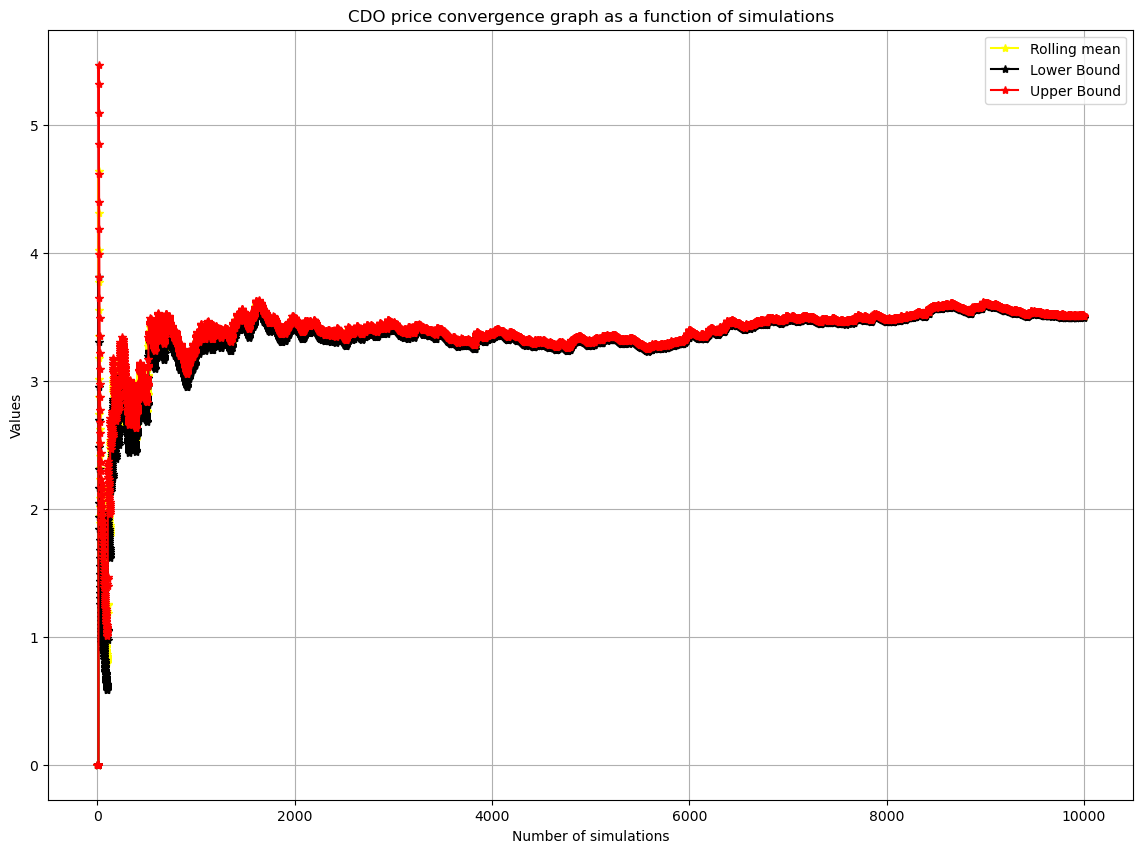

In [50]:
# Plotting the Convergence Graph
plt.figure(figsize=(14, 10))
plt.plot(x, y1, marker='*', linestyle='-', color='yellow', label='Rolling mean')
plt.plot(x, y2, marker='*', linestyle='-', color='black', label='Lower Bound')
plt.plot(x, y3, marker='*', linestyle='-', color='red', label='Upper Bound')

plt.xlabel('Number of simulations')
plt.ylabel('Values')
plt.title('CDO price convergence graph as a function of simulations')
plt.legend()
plt.grid(True)
plt.show()

The code effectively demonstrates a Monte Carlo simulation approach to model the risks associated with CDOs in a credit portfolio. It combines statistical techniques with financial risk modeling principles, providing insights into the potential losses, tranche impacts, and risk exposure within a CDO structure. The convergence graph serves as a critical tool for validating the reliability of the simulation results.